<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Nlp Classification Kaggle Competiton</b></h1>
</div>

laimporting Libraries

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from wordcloud import WordCloud
import plotly.graph_objects as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import plotly.express as px
import string
import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('/kaggle/input/nlp-kaggle-competition1/train.csv',index_col='id')


In [57]:
test = pd.read_csv('/kaggle/input/nlp-kaggle-competition1/test.csv',index_col='id')

In [32]:
df.head(1)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1


# Exploring Data

In [24]:
df.shape

(7613, 5)

In [25]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [26]:
df.isna().mean()

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

<div style="background-color:#8B0000; border-radius:5px; border:#ffffff solid; padding: 20px; font-size:120%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Spliting Data</b></h1>
</div>

In [39]:
from sklearn.model_selection import train_test_split
X = df.drop('target',axis = 1)
Y = df['target']
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=.25)
train_x.shape, test_x.shape

((5709, 3), (1904, 3))

<Axes: xlabel='target'>

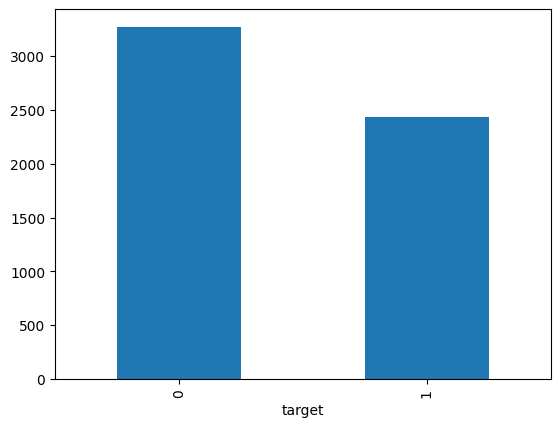

In [36]:
# ploting target
ytrain.value_counts().plot(kind='bar')

# Creating class for preprocess data

In [ ]:
# To lower
# remove stopword
# remove punctuations
# remove white space
# wordnetlemmatizer

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
import string
from nltk.corpus import stopwords
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class PreprocessText(BaseEstimator,TransformerMixin):
    def __init__(self,column):
        self.punc = string.punctuation
        self.column = column
        self.stop_words = stopwords.words('english')
        self.lemmatizer = WordNetLemmatizer()
        super().__init__()
    
    def fit(self,X,Y=None):
        return self
    
    def toLower(self,sent:str):
        if(type(sent) == str):
            return sent.lower()
        return sent
    
    def removePunc(self,sent:str):
        return sent.translate(str.maketrans("","",self.punc))
    
    def removeStopword(self,sent:str):
        words = word_tokenize(sent)
        return " ".join([w for w in words if w not in self.stop_words])
        
    def removeWhiteSpace(self,sent:str):
        return " ".join(sent.split())
        
    def removeDigits(self,sent):
        return " ".join(re.findall(r"\D+",sent))
    
    def removeMentions(self,text:str):
        # Remove Usernames and Mentions
        text = re.sub(r'@\w+', '', text)
        return text
    
    def removeLinks(self,text:str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        return text
    
    def transform(self,X,Y=None):
        X_transform = X.copy()
        X_transform[self.column] =  X[self.column].apply(self.removeMentions).apply(self.removeLinks).apply(self.toLower).apply(self.removePunc).apply(self.removeStopword).apply(self.removeDigits).apply(self.removeWhiteSpace)
        return X_transform[self.column]

In [41]:
PreprocessText('text').fit_transform(train_x)

id
836      fedex longer transport bioterror pathogens wak...
4398                                    kindly follow back
8318     steve buscemi firefightr b fame amp workd hr s...
7130     listen live author interview beth underwood gr...
7352     fun instagramers jeb bush said earlier week wa...
                               ...                        
7002                          liked video gun range mayhem
1114                                   like literally blew
10434    win lisowski whitewashes whirlwind round shang...
3395     china detains seven christians trying protect ...
5807     hail mary full grace lord thee blessed art tho...
Name: text, Length: 5709, dtype: object

# Building Model

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from time import time
from tqdm.notebook import tqdm

In [45]:
preprocessor = ColumnTransformer(transformers=[('preprocess text',PreprocessText('text'),['text'])])
models = [('mnb',MultinomialNB()),
         ('ber',BernoulliNB()),
         ('random forest',RandomForestClassifier()),
         ('logistic',LogisticRegression()),
         ('support vector',SVC()),
         ('decision tree',DecisionTreeClassifier()),
         ('xgboost',XGBClassifier()),
         ('catboost',CatBoostClassifier()),
         ('light',LGBMClassifier())]

scores = []
# pre_scores = []
confussion_mat = []
times = []

for (name,model) in tqdm(models):
    t1  = time()
    print(f"Processing model{name}")
    pipe = Pipeline([('preprocess',PreprocessText('text')),
                    ('tfidf',TfidfVectorizer()),
                    ('classifier', model)
                    ])
    pipe.fit(train_x,train_y)
    y_pred =  pipe.predict(test_x)
    score = accuracy_score(y_pred = y_pred,y_true=test_y)
    conf_mat = confusion_matrix(y_pred=y_pred,y_true=test_y)
#     pre_score = precision_score(y_pred=y_pred,y_true=test_y)
    confussion_mat.append((name, conf_mat))
    scores.append((name,score))
#     pre_score.append((name,pre_scores))
    t2 = time()
    times.append((name,t2-t1))

                                 

  0%|          | 0/9 [00:00<?, ?it/s]

Processing modelmnb
Processing modelber
Processing modelrandom forest
Processing modellogistic
Processing modelsupport vector
Processing modeldecision tree
Processing modelxgboost
Processing modelcatboost
Learning rate set to 0.021676
0:	learn: 0.6910372	total: 107ms	remaining: 1m 46s
1:	learn: 0.6893103	total: 149ms	remaining: 1m 14s
2:	learn: 0.6873635	total: 190ms	remaining: 1m 2s
3:	learn: 0.6850147	total: 231ms	remaining: 57.4s
4:	learn: 0.6832674	total: 272ms	remaining: 54.1s
5:	learn: 0.6818870	total: 313ms	remaining: 51.9s
6:	learn: 0.6800274	total: 354ms	remaining: 50.2s
7:	learn: 0.6784114	total: 395ms	remaining: 49s
8:	learn: 0.6767950	total: 435ms	remaining: 47.9s
9:	learn: 0.6756859	total: 476ms	remaining: 47.1s
10:	learn: 0.6737149	total: 515ms	remaining: 46.3s
11:	learn: 0.6721601	total: 556ms	remaining: 45.8s
12:	learn: 0.6707858	total: 596ms	remaining: 45.3s
13:	learn: 0.6695528	total: 636ms	remaining: 44.8s
14:	learn: 0.6679320	total: 676ms	remaining: 44.4s
15:	learn:

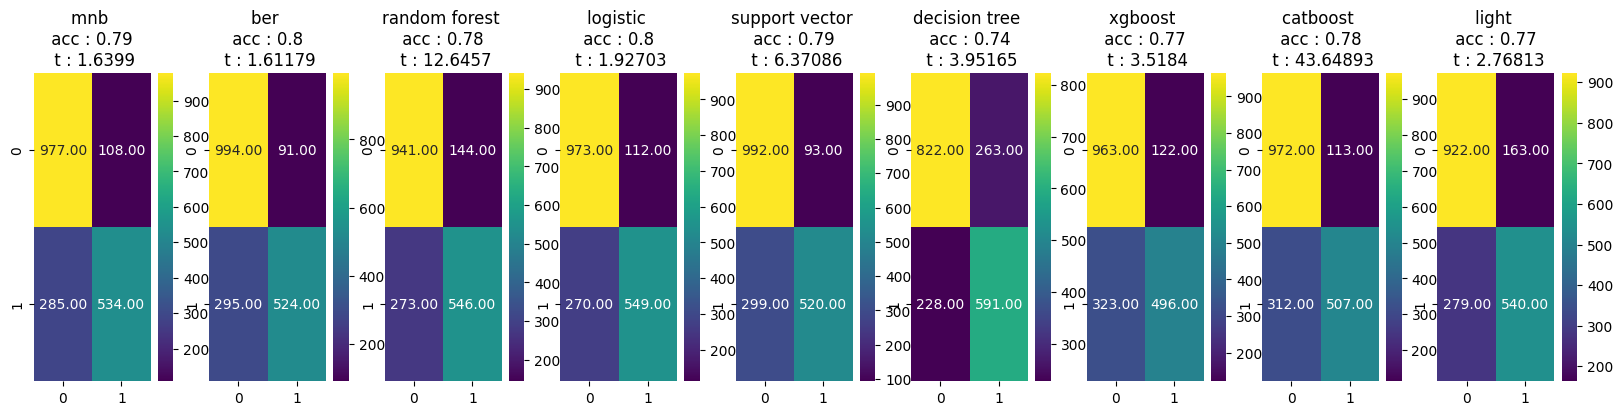

In [51]:
fig,ax = plt.subplots(1,9,figsize=(20,4))
for i,(name,conf_mat) in enumerate(confussion_mat):
    sns.heatmap(conf_mat,ax=ax[i], cmap='viridis', annot=True, fmt=".2f")
    ax[i].set_title(f'{name} \n acc : {round(scores[i][1],2)} \n t : {round(times[i][1],5)}')
plt.show()